# **Tanzeel Velaskar**
# **22B2198**
### CS 419M Assignment 1
### Assignment 26: Feature Engineering with Basis Functions (φᵢ)

# Feature Engineering with Basis Functions for FinTech Fraud Detection

In this notebook, I shall use basis functions (φᵢ) to engineer features from raw financial transactions and apply them to fraud detection. I shall then demonstrate how log transformations, time-based functions and categorical encodings improve model performance.

### Import all the necessary libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

### Load Dataset
Next, the CSV file will be directly obtained from GitHub so that this notebook is fully reproducible.

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/TanzeelMV/cs419m_assignment1Dataset/refs/heads/main/financial_fraud_dataset.csv"

df = pd.read_csv(url)
df.head()

,transaction_id,timestamp,amount,merchant_category,customer_id,customer_age,customer_location,device_type,previous_transactions,is_fraud
0,916306a3-f7e2-4371-992a-38ab8030b680,02-01-2022 06:53,46.93,fuel,bef45806-a255-4cdb-a45e-012d533eee34,48,NY,tablet,2,0
1,2d922a41-edd9-4649-81f0-c599db4b923d,05-09-2024 14:18,301.01,electronics,f600bad0-d244-42c4-9db3-1115214dd1c4,58,IL,mobile,4,0
2,9d2ec6cd-f8ed-4c68-9ec7-1450c30b7fe0,07-12-2022 06:24,131.67,entertainment,050c0996-fd20-4ce0-94ec-b1bbc1f3c229,23,TX,tablet,2,0
3,f65f1e63-1b91-4a79-95e4-4dd825992461,19-08-2022 03:58,91.29,fashion,71693a5a-7103-4876-9e03-0fcb64ba3e28,69,FL,desktop,6,0
4,e6a8161d-4fdc-4483-9b61-2c8c86567e78,19-04-2023 12:55,16.96,fashion,18ed5ca8-d0eb-4ccf-b4d3-fa37f15b89c7,48,TX,tablet,0,0


## Baseline Model (Raw Features)

We will start with a baseline logistic regression using only raw numerical features.

In [3]:
# Separate target and features
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

# Raw numeric + categorical features
num_features = ["amount", "customer_age", "previous_transactions"]
cat_features = ["merchant_category", "customer_location", "device_type"]

# Preprocessor
baseline_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

# Baseline pipeline
baseline_pipeline = Pipeline([
    ("preprocessor", baseline_preprocessor),
    ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
])

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test_b = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit baseline
baseline_pipeline.fit(X_train, y_train)

# Predictions
from sklearn.metrics import classification_report, roc_auc_score

y_pred_baseline = baseline_pipeline.predict(X_test)
print("=== Baseline Model Performance ===")
print(classification_report(y_test_b, y_pred_baseline))
print("ROC-AUC:", roc_auc_score(y_test_b, baseline_pipeline.predict_proba(X_test)[:,1]))


=== Baseline Model Performance ===
              precision    recall  f1-score   support

           0       0.99      0.54      0.70      2944
           1       0.02      0.59      0.05        56

    accuracy                           0.54      3000
   macro avg       0.50      0.56      0.37      3000
weighted avg       0.97      0.54      0.69      3000

ROC-AUC: 0.567971176242236


## Feature Engineering with Basis Functions (φᵢ)

We now generate basis functions from raw features. For example:
* φ₁(x) = log(amount + 1)
* φ₂(x) = day_of_week(timestamp)
* φ₃(x) = hour_of_day(timestamp)

In [4]:
# Parse timestamp and create basis functions
df['log_amount'] = np.log1p(df['amount'])

df['timestamp'] = pd.to_datetime(df['timestamp'], format="%d-%m-%Y %H:%M")

df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour_of_day'] = df['timestamp'].dt.hour

## Selecting Features and Target

We keep engineered features (φᵢ) and categorical variables for fraud detection.

In [5]:
X = df[['log_amount', 'day_of_week', 'hour_of_day',
        'merchant_category', 'customer_age', 'customer_location',
        'device_type', 'previous_transactions']]

y = df['is_fraud']

## Preprocessing

We use One-Hot Encoding for categorical variables and pass numeric features directly using StandardScaler.

In [6]:
categorical = ['merchant_category', 'customer_location', 'device_type']
numeric = ['log_amount', 'day_of_week', 'hour_of_day', 'customer_age', 'previous_transactions']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', StandardScaler(), numeric)
    ]
)

# X.head()

## Train-Test Split

We split the dataset into training and testing sets with stratification to preserve fraud/non-fraud ratio.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## Model Training

We train a Logistic Regression classifier inside a pipeline with preprocessing.

In [8]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant_category',
                                                   'customer_location',
                                                   'device_type']),
                                                 ('num', StandardScaler(),
                                                  ['log_amount', 'day_of_week',
                                                   'hour_of_day',
                                                   'customer_age',
                                                   'previous_transactions'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## Model Evaluation

We evaluate with precision (how many flagged frauds are correct) and recall (how many actual frauds were caught).

In [9]:
y_pred = clf.predict(X_test)

# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

print("\n=== Engineered Model Performance ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))


=== Engineered Model Performance ===
              precision    recall  f1-score   support

           0       0.99      0.54      0.70      2944
           1       0.03      0.66      0.05        56

    accuracy                           0.54      3000
   macro avg       0.51      0.60      0.38      3000
weighted avg       0.97      0.54      0.69      3000

ROC-AUC: 0.565138538431677


## Results and Visualization

In [10]:
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, (y_pred if model_name=="Baseline" else y_pred))
    }

baseline_results = evaluate_model(y_test_b, y_pred_baseline, "Baseline")
fe_results = evaluate_model(y_test, y_pred, "Engineered")

comparison_df = pd.DataFrame([baseline_results, fe_results])
comparison_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Baseline,0.541333,0.023810,0.589286,0.045770,0.564853
1,Engineered,0.543667,0.026676,0.660714,0.051282,0.601077


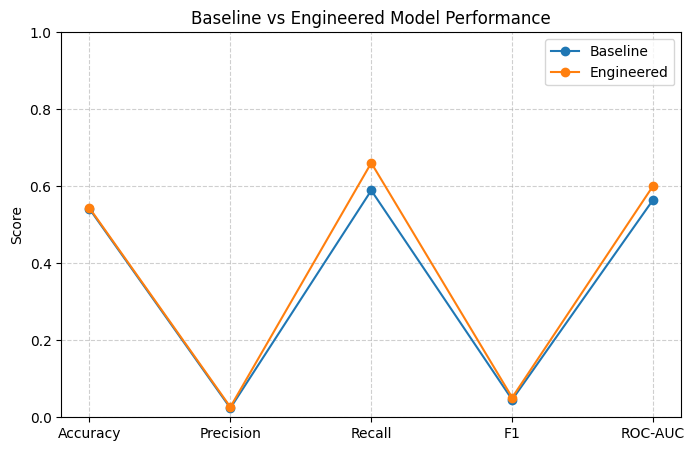

In [11]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

plt.figure(figsize=(8,5))
plt.plot(metrics, comparison_df.loc[0, metrics], marker="o", label=comparison_df.loc[0, "Model"])
plt.plot(metrics, comparison_df.loc[1, metrics], marker="o", label=comparison_df.loc[1, "Model"])

plt.title("Baseline vs Engineered Model Performance")
plt.ylabel("Score")
plt.ylim(0,1)  # since metrics are between 0 and 1
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# **Wiki Article**



# Feature Engineering with Basis Functions for FinTech Fraud Detection  

## 1. Overview  

Feature engineering is the process of constructing new variables from existing data to improve the performance of machine learning models. Instead of relying only on raw attributes, the data is transformed to highlight important relationships.  

In this project, basis functions ($\phi_i$) were applied to transform financial transaction attributes into richer representations for fraud detection. Two approaches were compared:  
- A **baseline model**, which used only raw attributes such as transaction amount and merchant category.  
- An **engineered model**, which applied transformations to these attributes.  

The dataset was obtained from Kaggle [Ziya, 2023].  

---

## 2. Methodology  

Several types of basis function transformations were applied to the dataset.  

### Logarithmic Transformation  
The transaction amount was transformed as:  

$$
\phi_1(\text{amount}) = \log(\text{amount} + 1)
$$  

This reduces the influence of very large amounts (common in fraud) while amplifying differences in smaller ones.  
For example:  
- The difference between 10 and 100 becomes more meaningful than the difference between 10,000 and 11,000.  

### Temporal Features  
Derived from timestamps, two features were extracted:  
- **Day of the week**  
- **Hour of the day**  

Fraud often happens at unusual times. For instance, a user who normally transacts at 2 p.m. but suddenly makes a transaction at 3 a.m. could be suspicious.  

### Categorical Encodings  
Applied to merchant category, device type and location using one-hot encoding.  
This allows the model to recognize, for example, that a user suddenly purchasing expensive electronics instead of groceries may be engaging in fraudulent behavior.  

### Behavioral Features  
Engineered to capture user patterns, such as:  
- **Number of past transactions** within a time window (e.g., rapid multiple purchases may suggest stolen card usage).  
- **Frequency of device changes**, which may indicate account takeover attempts.  

### Feature Vector Summary  

$$
\Phi(x) = [\phi_1(\text{amount}), \phi_2(\text{timestamp}), \phi_3(\text{timestamp}), \ldots, \text{one-hot}(\text{merchant, device, location}), \text{behavioral features}]
$$  

---

## 3. Multilingual Data Handling  

In real-world financial systems, transaction descriptions could include multiple languages. Although this project did not implement multilingual handling, strategies for Indian and global FinTech scenarios can be considered.

One approach could be to extract keyword features, such as detecting words like lottery in English, लॉटरी in Hindi, or லாட்டரி in Tamil, which might indicate suspicious activity.

Another possible strategy could be language normalization, where synonyms across languages are mapped to a single feature. For example, “bazaar,” “market,” and “बाज़ार” (Hindi for bazaar) could all be grouped under a general “retail marketplace” category.

Finally, embeddings from multilingual models such as fastText could be used. This would place semantically similar words like “electronics” and “इलेक्ट्रॉनिक्स” in Hindi close together in vector space.

While not implemented in this project, these techniques could help FinTech platforms that handle multilingual Indian transaction streams.  

---

## 4. FinTech Applications  

The engineered features directly support fraud detection in real-world FinTech systems.

Time-based features enable anomaly detection, such as late-night transactions at unusual hours. Device and location encodings help flag mismatches, for example when a login happens in Mumbai and minutes later a transaction is attempted in London. Merchant category features highlight abnormal spending patterns, such as sudden luxury purchases by users who usually buy groceries.

These engineered representations convert raw transaction logs into signals that fraud detection models can exploit effectively.

---

## 5. Implementation

The workflow consisted of **data ingestion**, **feature engineering**, and **model training**.  

A logistic regression classifier was used, which estimates the probability of fraud as:  

$$
P(y=1|x) = \sigma(w^T \Phi(x) + b)
$$  

where:  
- $\Phi(x)$ is the engineered feature vector,  
- $w$ is the weight vector,  
- $b$ is the bias,  
- $\sigma(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function.  

The model is trained by minimizing the **log loss**:  

$$
L(w,b) = -\frac{1}{N} \sum_{i=1}^N \Big[ y_i \log P(y_i|x_i) + (1-y_i)\log(1-P(y_i|x_i)) \Big]
$$  

This ensures the model assigns high probability to true frauds and low probability to legitimate transactions. The engineered features make $w^T \Phi(x)$ more discriminative between fraud and non-fraud.  

---

## 6. Evaluation Metrics  

Fraud detection is a highly imbalanced problem, where fraudulent cases are rare compared to legitimate ones. Relying on accuracy alone can be misleading.  

-- **TP (True Positive):** A fraudulent transaction correctly predicted as fraud.  
-- **TN (True Negative):** A normal transaction correctly predicted as normal.  
-- **FP (False Positive):** A normal transaction incorrectly predicted as fraud (false alarm).  
-- **FN (False Negative):** A fraudulent transaction incorrectly predicted as normal (missed fraud).  

- **Accuracy**:  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$  
A model that predicts “non-fraud” for everything may still reach 99% accuracy if fraud is only 1% of transactions.  

- **Precision**:  
$$
\text{Precision} = \frac{TP}{TP + FP}
$$  
Measures how many predicted frauds are truly fraud. High precision avoids false alarms.  

- **Recall**:  
$$
\text{Recall} = \frac{TP}{TP + FN}
$$  
Measures how many actual frauds were caught. High recall is critical to minimize financial loss.  

- **F1-score**:  
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$  
Balances precision and recall.  

- **ROC-AUC**: Represents the probability that a random fraud case is ranked higher than a random non-fraud case.  

### Results Summary  

| Model       | Accuracy | Precision | Recall | F1    | ROC-AUC |  
|-------------|----------|-----------|--------|-------|---------|  
| Baseline    | 0.541    | 0.0238    | 0.5893 | 0.0458| 0.5649  |  
| Engineered  | 0.544    | 0.0267    | 0.6607 | 0.0513| 0.6011  |  

### Interpretation  

The engineered model significantly improved **recall** (from 58.9% to 66.1%), meaning it caught more fraudulent transactions. ROC-AUC also increased, showing that engineered features helped the model distinguish fraud from legitimate activity more consistently. Even though precision remained low, this is expected in imbalanced fraud detection problems.  

---

## References  

- Bhattacharyya, S., Jha, S., Tharakunnel, K., & Westland, J. C. (2011). *Data mining for credit card fraud: A comparative study.* Decision Support Systems, 50(3), 602–613.  
- Jurgovsky, J., Granitzer, M., Ziegler, K., Calabretto, S., Portier, P. E., He-Guelton, L., & Caelen, O. (2018). *Sequence classification for credit-card fraud detection.* Expert Systems with Applications, 100, 234–245.  
- Sahin, Y., & Duman, E. (2011). *Detecting credit card fraud by decision trees and support vector machines.* International MultiConference of Engineers and Computer Scientists.  
- Ziya, M. (2023). *Financial transaction for fraud detection research dataset.* Kaggle. Retrieved from [ https://www.kaggle.com/datasets/ziya07/financial-transaction-for-fraud-detection-research ]
